# Clustering with DBSCAN and K-Means

**Group 5**:
- Elias Maria Bonasera (2149751)
- Alberto Casellato (2139206)
- Nicola Garbin (2156363)
- Francesco Pazzocco (2165861)

In [1]:
%matplotlib inline
import os
os.environ["OMP_NUM_THREADS"] = "3"

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
import matplotlib.cm as cm
colormap= cm.viridis
plt.rcParams['font.size'] = 12

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [2]:
fname,fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)
x=data

N= 600   L=D= 12


### Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for $\varepsilon$

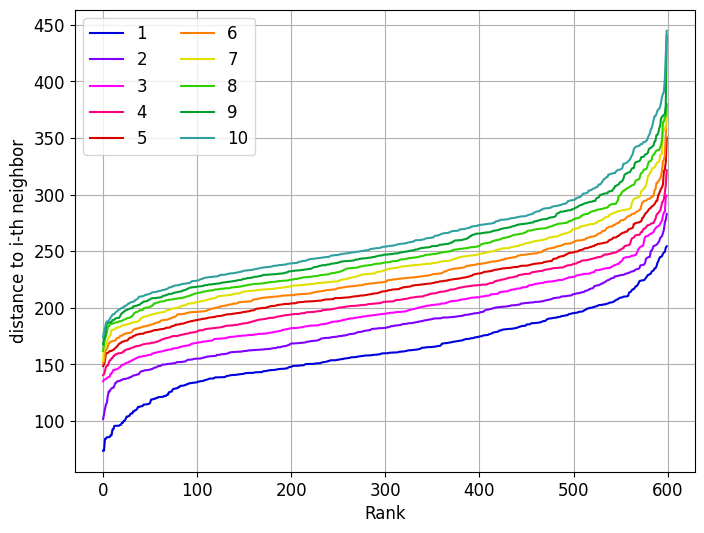

mean minimum distance between points:  162.34622464324366


In [3]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]

plt.figure(figsize=(8, 6))
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("Rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.grid()
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ",mean_min_dist)

DBSCAN requires each core point to have a certain number of neighbors ($\text{minPts}$) within the radius $\varepsilon$. This graph shows how many points turns into core points at a fixed radius $\varepsilon$ for a fixed $\text{minPts=i}$ corresponding to the $i$-th neighbour curve. 

The optimal $\varepsilon$ corresponds to the knee points of each graph; in fact it represents the transition where the distance to the $\text{minPts}$-th neighbor suddenly increases.

##### Detection of the knee point
After the detection of the optimal $\varepsilon$ we are going to build the heatmap inside a range sample centered around that value
$[\varepsilon- \delta,\; \varepsilon + \delta]$.

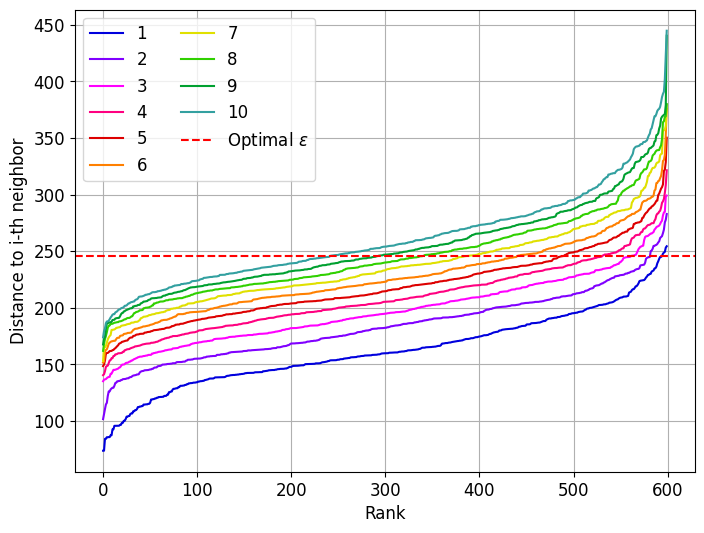

Optimal epsilon for DBSCAN: 246.099


In [4]:
from kneed import KneeLocator

k = 3

sorted_distances = np.sort(dd[k]) 

knee = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")

plt.figure(figsize=(8, 6))
for i in range(1, nn+1):
    plt.plot(np.sort(dd[i]), c=listc[i-1], label=str(i))

plt.axhline(y=sorted_distances[knee.knee], color='r', linestyle='--', label=fr'Optimal $\epsilon$')
plt.xlabel("Rank")
plt.ylabel("Distance to i-th neighbor")
plt.legend(ncol=2)
plt.grid()
plt.show()
optimal_epsilon = sorted_distances[knee.knee]
print(f"Optimal epsilon for DBSCAN: {optimal_epsilon:.3f}")

### NMI heatmap

In [5]:
def run_dbscan(X, eps=0.5, minPts=10):
    from sklearn.cluster import DBSCAN
    
    """
    Input
    - X: data
    - \varepsilon: essential for DBSCAN
    - minPts: essential for DBSCAN
    
    Output:
    - labels: cluster labels DBSCAN generated
    - n_noise: outlier points (-1)
    """
    
    db = DBSCAN(eps=eps, min_samples=minPts).fit(X)
    labels = db.labels_
    n_noise = np.sum(labels == -1)
    return labels, n_noise

def clustering(y):
    from collections import OrderedDict
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

In [6]:
from sklearn.metrics import normalized_mutual_info_score

minPts_values = np.arange(1, 11)

# sampling interval [ε - sigma{ε},\; ε \sigma{ε}]
eps_values = np.linspace(optimal_epsilon*0.8, optimal_epsilon*1.2, 20)

# Filling nmi_matrix via DBSCAN
nmi_matrix = np.zeros((len(eps_values), len(minPts_values)))
for i, eps in enumerate(eps_values):
    for j, minPts in enumerate(minPts_values):
        labels, _ = run_dbscan(x, eps=eps, minPts=minPts)
        nmi_matrix[i, j] = NMI(y, labels)

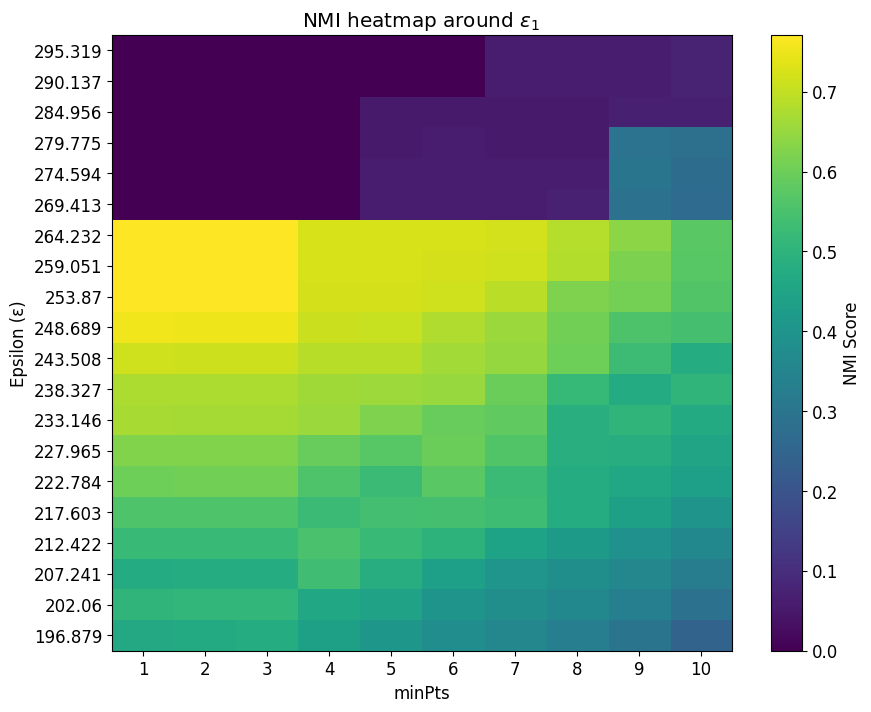

In [7]:
# Plot with color mapping grid
plt.figure(figsize=(10, 8))
plt.imshow(nmi_matrix, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label="NMI Score")
plt.xticks(ticks=np.arange(len(minPts_values)), labels=minPts_values)
plt.yticks(ticks=np.arange(len(eps_values)), labels=np.round(eps_values, 3))
plt.xlabel("minPts")
plt.ylabel("Epsilon (ε)")
plt.title("NMI heatmap around $ε_1$ ")
plt.show()

##### *Correlation Between ε and $\textbf{minPts}$*
When DBSCAN’s clustering quality (measured by NMI) is high, the chosen pair  ε and $\text{minPts}$ is well-tuned to the data density.
The area between $\varepsilon \in [248,264]$ and $\text{minPts} \in [1,3]$ has a *high NMI*, which means that *DBSCAN is performing well* in this parameter range.


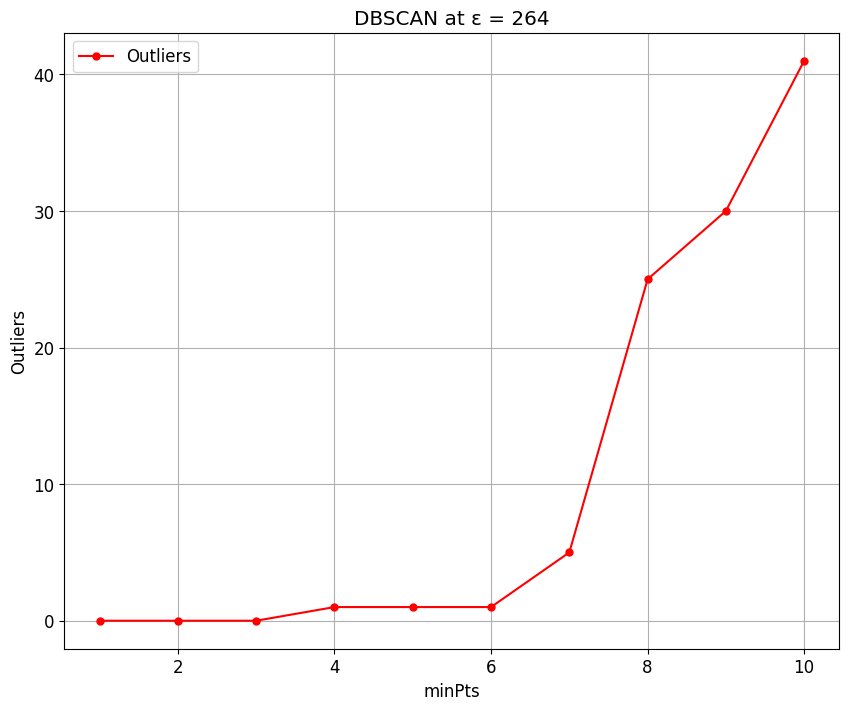

In [8]:
minPts_range = range(1, 11)
outliers = []
optimal_ε=264

# DBSCAN
for minPts in minPts_range:
    labels, n_noise = run_dbscan(x, eps=optimal_ε, minPts=minPts)
    outliers.append(n_noise)

# Plot del numero di outlier
plt.figure(figsize=(10, 8))
plt.plot(minPts_range, outliers, 'r-o', label="Outliers", markersize=5)
plt.xlabel("minPts")
plt.ylabel("Outliers")
plt.title(f"DBSCAN at ε = {optimal_ε}")
plt.grid()
plt.legend()
plt.show()

We included the outlier plot to check if the minPts selection from the NMI heatmap does not exclude too many points from clusters. This ensures that DBSCAN is selective enough without being overly restrictive, avoiding an excessive number of outliers.
This graph shows how minPts=4 is a turning point from witch the DBSCAN algoritm starts counting as outliers some points.
Comparing with the NMI heatmap and, since optimal minPts is below the critical outlier rise, it is possible to conclude that every point belongs to a cluster.

## PCA to visualize the data structure


PCA transforms the dataset $X$ into a new orthogonal basis where each axis (principal component) maximizes the variance. The covariance matrix is diagonalized, and its eigenvectors define the principal directions. Below, we compute the first two principal components and analyze the explained variance.


In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=x.shape[1])
X_pca = pca.fit_transform(x)

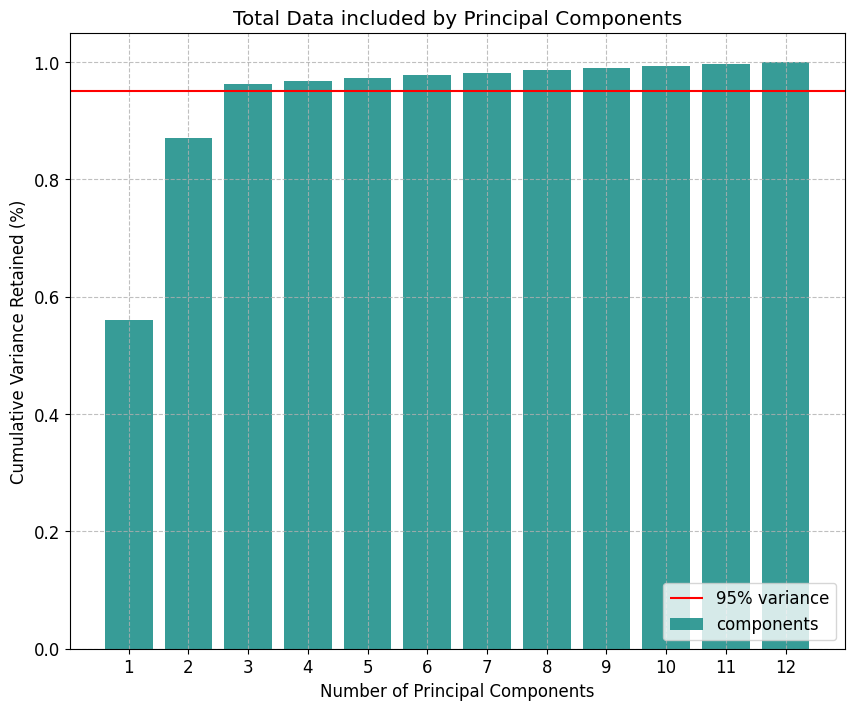

In [10]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
x_values = range(1,len(cumulative_variance)+1)

plt.figure(figsize=(10, 8))
plt.bar(x_values, cumulative_variance, color=colormap(1/2), alpha=0.9, label="components")
xlim = plt.xlim()
plt.hlines(0.95, xmin=xlim[0], xmax=xlim[1], color="r", label="95% variance")

plt.legend(loc="lower right")
plt.xticks(x_values)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Retained (%)')
plt.title('Total Data included by Principal Components')
plt.xlim(xlim)
plt.grid(linestyle="--", alpha=.8)
plt.show()

This graph shows how much data is retained as more Principal Components (PCs) are included. The first three components include the majority of the variance (>95%).

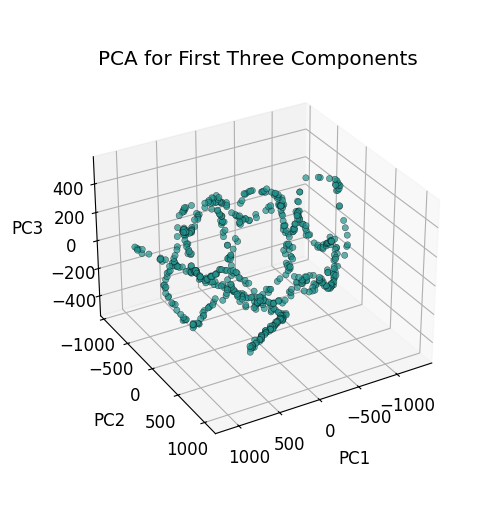

In [11]:
%config InlineBackend.print_figure_kwargs = {'pad_inches': .5}

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(projection='3d')
ax.set_title('PCA for First Three Components')
ax.scatter(
    X_pca[:, 0],  # PC1
    X_pca[:, 1],  # PC2
    X_pca[:, 2],  # PC3
    marker='o', 
    color=colormap(1/2),
    alpha=0.7,
    edgecolor="k",
    linewidth=.3
)

ax.set_xlabel('PC1', labelpad=10)
ax.set_ylabel('PC2', labelpad=10)
ax.set_zlabel('PC3', labelpad=10)
ax.view_init(elev=30, azim=60)
plt.show()

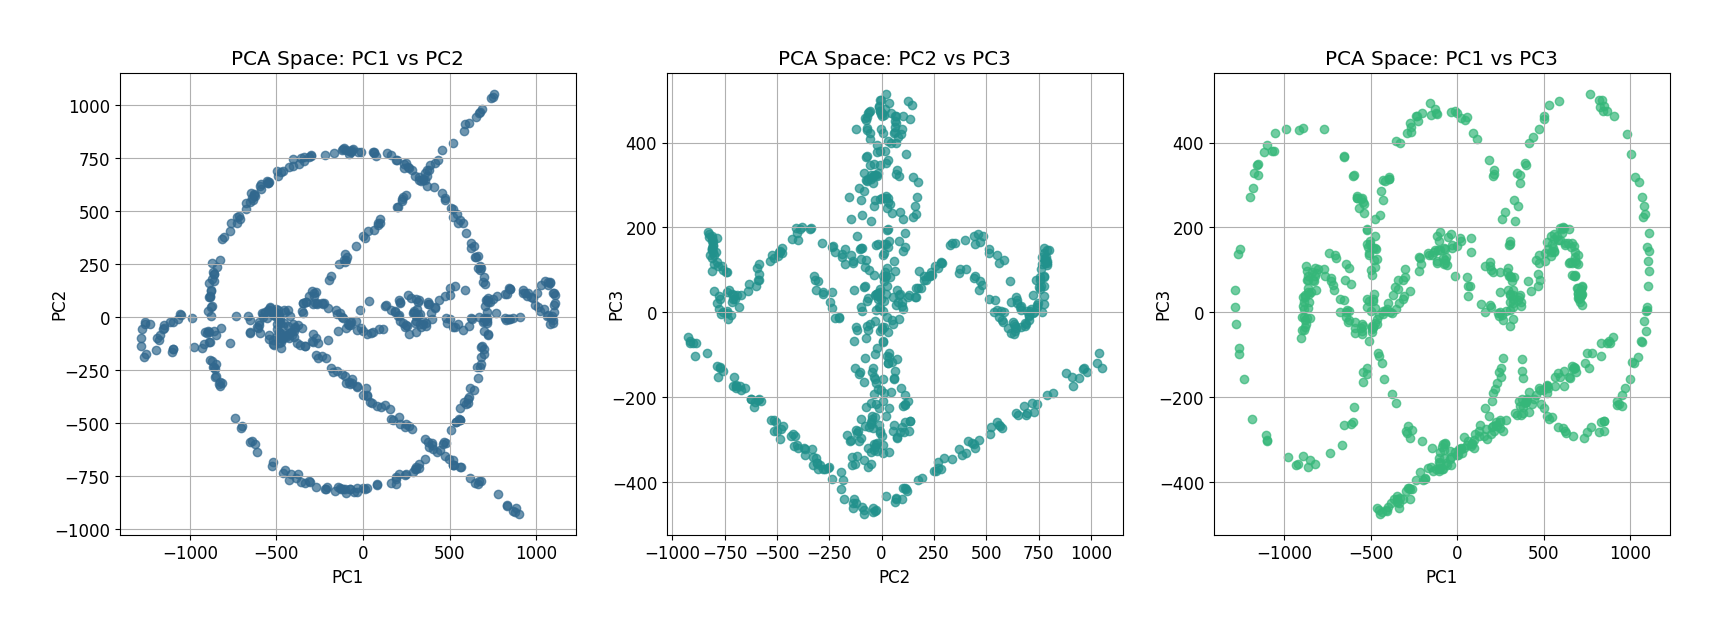

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# PC1 vs PC2
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], color=colormap(0.333), alpha=0.7)
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2", labelpad=-10)
axes[0].set_title("PCA Space: PC1 vs PC2")
axes[0].grid()

# PC2 vs PC3
axes[1].scatter(X_pca[:, 1], X_pca[:, 2], color=colormap(0.5), alpha=0.7)
axes[1].set_xlabel("PC2")
axes[1].set_ylabel("PC3", labelpad=-10)
axes[1].set_title("PCA Space: PC2 vs PC3")
axes[1].grid()

# PC1 vs PC3
axes[2].scatter(X_pca[:, 0], X_pca[:, 2], color=colormap(0.666), alpha=0.7)
axes[2].set_xlabel("PC1")
axes[2].set_ylabel("PC3", labelpad=-10)
axes[2].set_title("PCA Space: PC1 vs PC3")
axes[2].grid()

plt.show()

### K-means

In [13]:
from sklearn.cluster import KMeans

def run_kmean(X, n=3):
    """
    Imput
    - X: data
    - n
    """
    kmean = KMeans(n)
    y_fit = kmean.fit_predict(X)
    return y_fit

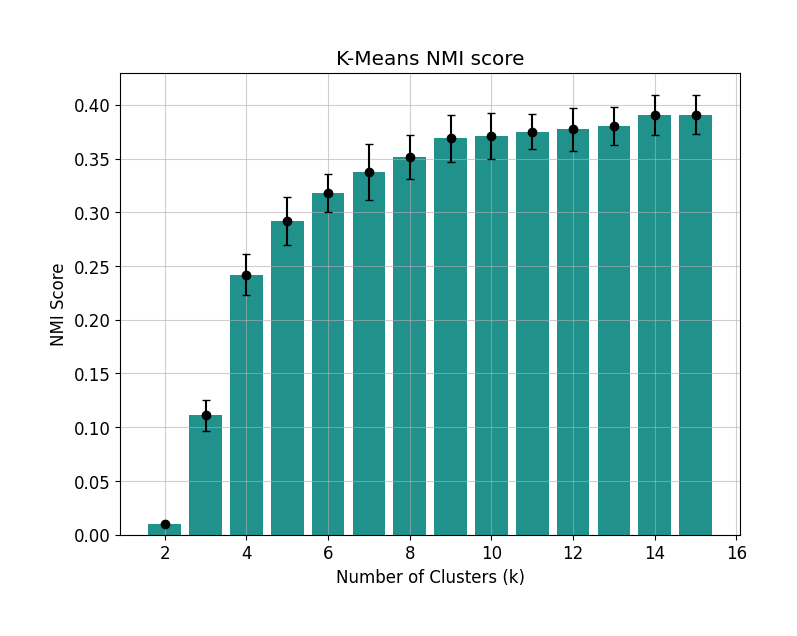

In [14]:
k_values = np.arange(2, 16)  # Trying k from 2 to 10
nmi_scores = []
nmi_stds = []
for k in k_values:
    list_values = []
    for _ in range(50):
        test = run_kmean(X_pca, k)
        list_values.append(normalized_mutual_info_score(y, test))
    nmi_mean = np.mean(list_values)
    nmi_std = np.std(list_values)
    
    nmi_scores.append(nmi_mean)
    nmi_stds.append(nmi_std)

# Plot NMI vs k
plt.figure(figsize=(8, 6))
# plt.plot(k_values, nmi_scores, marker='o', linestyle='-', color=colormap(1/2))
plt.bar(k_values, nmi_scores, color=colormap(1/2))
plt.errorbar(k_values, nmi_scores, yerr=nmi_stds, marker='o', linestyle='', color="k", capsize=3)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("NMI Score")
plt.title("K-Means NMI score")
plt.grid(alpha=0.6)
plt.show()

In this graph the NMI increases as $k$ grows, this suggests that the clustering solution matches more and more the true structure of the data, even though we know that the correct number of clusters is $k=3$.
This one gives an NMI score of approximately 0.12. 

This poor performance is due to the limitations of both PCA and k-means algorithm. PCA reduces the dimensions of the original dataset giving a structure in which k-means does not perform optimally. In fact, k-means works well only when clusters are spherically distributed.

The NMI improvement with the increase of $k$ suggests an *over-segmentation* of the true clusters into smaller, spherical sub-clusters.

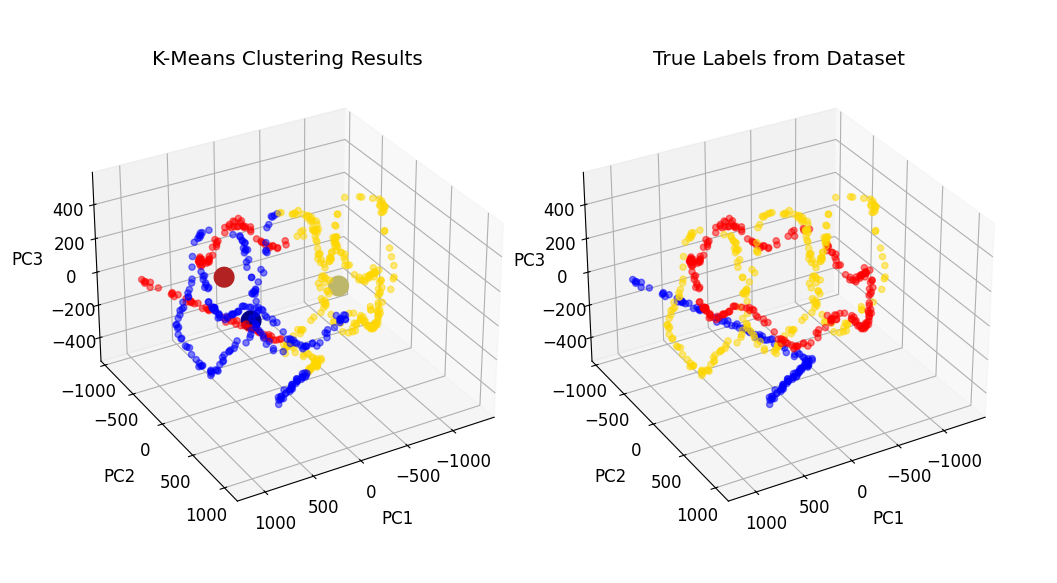

In [15]:
%config InlineBackend.print_figure_kwargs = {'pad_inches': .5}

from sklearn.cluster import KMeans

k = 3  # Explicitly define the number of clusters (matches true labels)

# Fit K-Means on PCA-transformed data (X_pca from earlier cells)
kmeans = KMeans(n_clusters=k, init='random', n_init='auto', max_iter=50)
kfit = kmeans.fit(X_pca)  # No transposing needed
kcentroids = kmeans.cluster_centers_
kclusters = kmeans.labels_

# Color mappings
kcentroids_colors = ['firebrick', 'darkkhaki', 'darkblue']
kclusters_colors = []
for k in kclusters:
    if k == 0:
        kclusters_colors.append('red')
    elif k == 1:
        kclusters_colors.append('gold')
    elif k == 2:
        kclusters_colors.append('blue')

# True label colors (using PCA-transformed data)
y = y.ravel()
yclusters_colors = []
for label in y:
    if label == 0:
        yclusters_colors.append('red')
    elif label == 1:
        yclusters_colors.append('gold')
    elif label == 2:
        yclusters_colors.append('blue')

# Plotting
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_title('K-Means Clustering Results')
ax1.scatter(
    X_pca[:, 0],  # PC1
    X_pca[:, 1],  # PC2
    X_pca[:, 2],  # PC3
    marker='o', 
    color=kclusters_colors,
    alpha=0.5
)
ax1.scatter(
    kcentroids[:, 0], 
    kcentroids[:, 1], 
    kcentroids[:, 2], 
    s=200, 
    color=kcentroids_colors,
    zorder=10,
    alpha=1
)
ax1.set_xlabel('PC1', labelpad=10)
ax1.set_ylabel('PC2', labelpad=10)
ax1.set_zlabel('PC3', labelpad=10)
ax1.view_init(30, 60)
ax1.set_yticks(range(-1000,1001, 500))

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_title('True Labels from Dataset')
ax2.scatter(
    X_pca[:, 0],  # PC1
    X_pca[:, 1],  # PC2
    X_pca[:, 2],  # PC3 
    marker='o', 
    color=yclusters_colors,
    alpha=0.5
)
ax2.set_xlabel('PC1', labelpad=10)
ax2.set_ylabel('PC2', labelpad=10)
ax2.set_zlabel('PC3', labelpad=5)
ax2.view_init(30, 60)
ax2.set_yticks(range(-1000,1001, 500))

plt.tight_layout()
plt.show()

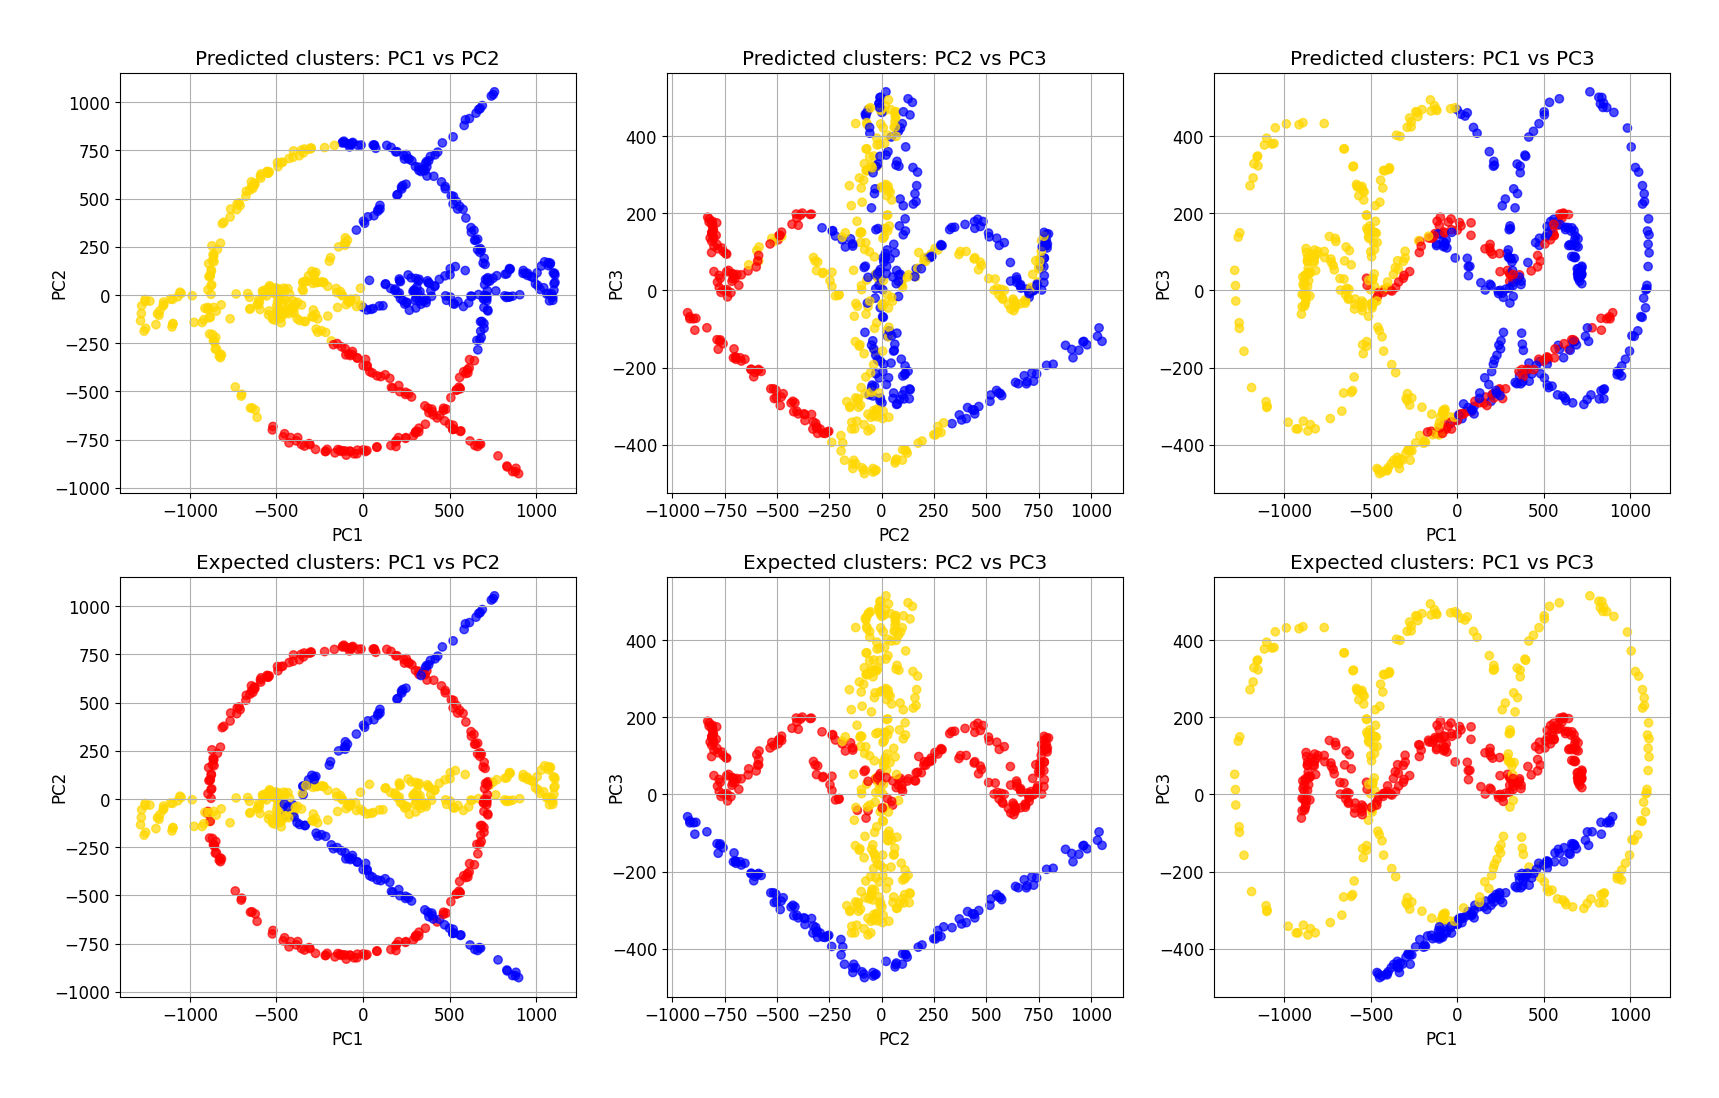

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

for i in range(2):
    colors = kclusters_colors if i==0 else yclusters_colors
    title =  "Predicted clusters" if i==0 else "Expected clusters"
    
    # PC1 vs PC2
    ax = axes[i,0]
    ax.scatter(X_pca[:, 0], X_pca[:, 1], color=colors, alpha=0.7)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2", labelpad=-10)
    ax.set_title(f"{title}: PC1 vs PC2")
    ax.grid()

    # PC2 vs PC3
    ax = axes[i,1]
    ax.scatter(X_pca[:, 1], X_pca[:, 2], color=colors, alpha=0.7)
    ax.set_xlabel("PC2")
    ax.set_ylabel("PC3", labelpad=-10)
    ax.set_title(f"{title}: PC2 vs PC3")
    ax.grid()

    # PC1 vs PC3
    ax = axes[i,2]
    ax.scatter(X_pca[:, 0], X_pca[:, 2], color=colors, alpha=0.7)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC3", labelpad=-10)
    ax.set_title(f"{title}: PC1 vs PC3")
    ax.grid()

plt.show()

With these plots we can notice the difference between the expected clusters and what we found through PCA and k-means algorithms. The results are considerably different, and it is also possible to notice how the k-means algorithm clustered data in a spherical distribution.

Comparing the results of DBSCAN and K-Means, we can see that DBSCAN performs better than K-Means because it can handle non-linear cluster shapes.